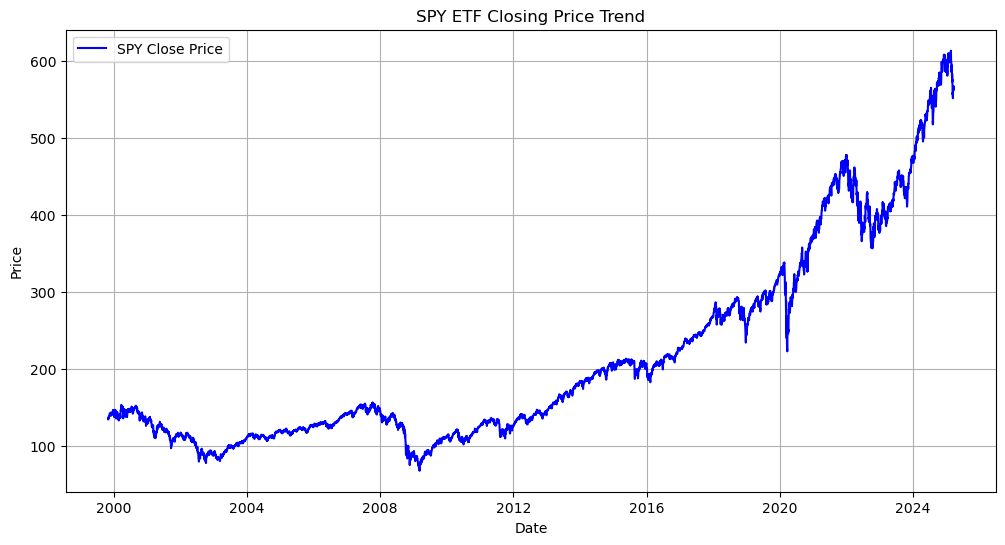

Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


135/135 ━━━━━━━━━━━━━━━━━━━━ 103s 748ms/step - loss: 0.0073 - mae: 0.0511 - val_loss: 8.5910e-04 - val_mae: 0.0235
Epoch 2/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 101s 746ms/step - loss: 6.0175e-04 - mae: 0.0166 - val_loss: 7.6718e-04 - val_mae: 0.0215
Epoch 3/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 73s 536ms/step - loss: 5.5294e-04 - mae: 0.0161 - val_loss: 0.0015 - val_mae: 0.0331
Epoch 4/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 62s 459ms/step - loss: 3.5223e-04 - mae: 0.0128 - val_loss: 5.6261e-04 - val_mae: 0.0186
Epoch 5/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 61s 452ms/step - loss: 4.8051e-04 - mae: 0.0146 - val_loss: 5.3342e-04 - val_mae: 0.0183
Epoch 6/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 60s 448ms/step - loss: 4.5766e-04 - mae: 0.0144 - val_loss: 0.0015 - val_mae: 0.0324
Epoch 7/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 60s 447ms/step - loss: 3.7882e-04 - mae: 0.0128 - val_loss: 7.7806e-04 - val_mae: 0.0226
Epoch 8/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 70s 520ms/step - loss: 3.2634e-04 - mae: 0.0123 - val_loss: 0.0013 - val_mae: 

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from alpha_vantage.timeseries import TimeSeries
from tensorflow.keras.callbacks import EarlyStopping
import datetime

# Alpha Vantage API Setup
API_KEY = "8GSUEKGWPTI4YGE3"
ts = TimeSeries(key=API_KEY, output_format='pandas')

# Fetching SPY ETF data using Alpha Vantage
data, meta_data = ts.get_daily(symbol='SPY', outputsize='full')

# Reverse data to have oldest to newest
spy_data = data.sort_index()
spy_data.columns = ['Open', 'High', 'Low', 'Close', 'Volume']

# Plotting trend
plt.figure(figsize=(12, 6))
plt.plot(spy_data['Close'], label='SPY Close Price', color='blue')
plt.title('SPY ETF Closing Price Trend')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Prepare Data for LSTM Model
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(spy_data['Close'].values.reshape(-1, 1))
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

prediction_days = 1000
epochs = 50

x_train, y_train = [], []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Build LSTM Model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
history = model.fit(x_train, y_train, epochs=epochs, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Save the model
model.save('advanced_spy_prediction_model.h5')



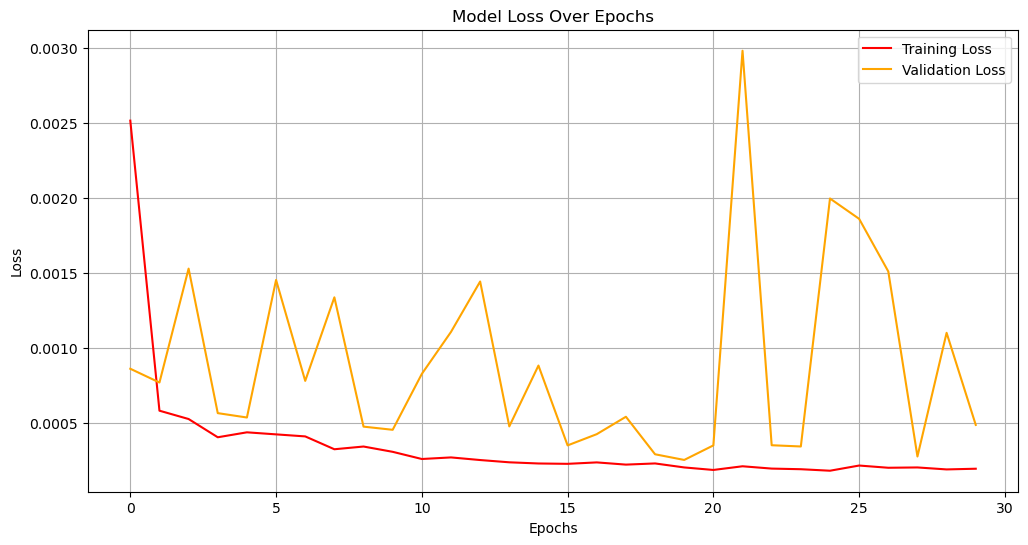

In [38]:
# Plot training & validation loss and accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss', color='red')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [40]:
# Kernel 1: Predict future stock price
model = load_model('advanced_spy_prediction_model.h5')
real_data = [scaled_data[-prediction_days:]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

predicted_price = model.predict(real_data)
predicted_price = scaler.inverse_transform(predicted_price)

print(f"Predicted SPY price for the next day: ${predicted_price[0][0]:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
Predicted SPY price for the next day: $557.54


Enter the initial year of investment (e.g., 2010):  2000


/var/folders/30/9fv2b9ms2gs4g886pqrhh3x80000gn/T/ipykernel_79168/138305614.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  current_price = spy_data['Close'][-1]


Enter investment amount (USD):  150000


If you invested $150000.00 in 2000, your investment would now be worth $591786.87, a return of 294.52%.


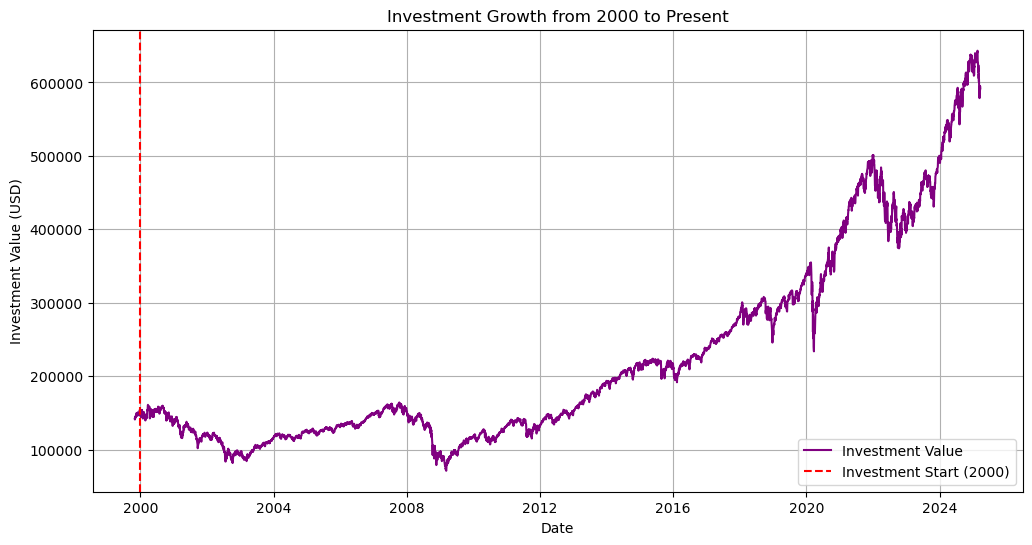

In [42]:
initial_year = int(input("Enter the initial year of investment (e.g., 2010): "))
initial_price = spy_data.loc[f'{initial_year}-01-01':f'{initial_year}-12-31']['Close'].mean()
current_price = spy_data['Close'][-1]

investment_amount = float(input("Enter investment amount (USD): "))
initial_shares = investment_amount / initial_price
current_value = initial_shares * current_price
return_percent = ((current_value - investment_amount) / investment_amount) * 100

# Print the investment return
print(f"If you invested ${investment_amount:.2f} in {initial_year}, your investment would now be worth ${current_value:.2f}, a return of {return_percent:.2f}%.")

# Create a new column for cumulative investment value over time
investment_value = (spy_data['Close'] / initial_price) * investment_amount

# Plot the investment value over time
plt.figure(figsize=(12, 6))
plt.plot(spy_data.index, investment_value, label='Investment Value', color='purple')

# Convert the initial investment date to datetime
investment_start_date = datetime.datetime.strptime(f'{initial_year}-01-01', '%Y-%m-%d')

# Add a vertical line to mark the start of the investment
plt.axvline(x=investment_start_date, color='red', linestyle='--', label=f'Investment Start ({initial_year})')

# Customize plot
plt.title(f'Investment Growth from {initial_year} to Present')
plt.xlabel('Date')
plt.ylabel('Investment Value (USD)')
plt.legend()
plt.grid(True)
plt.show()

In [44]:
years = int(input("Enter how many years into the future you want to predict: "))
investment_amount = float(input("Enter your investment amount: "))

# Calculate total days to predict based on given years
future_days = 365 * years

# Prepare input for prediction
future_input = scaled_data[-prediction_days:].reshape(1, prediction_days, 1)
future_predictions = []

# Generate future predictions
for _ in range(future_days):
    future_price = model.predict(future_input)
    future_predictions.append(future_price[0, 0])
    
    # Reshape future_price to ensure correct dimensions for concatenation
    future_price = future_price.reshape(1, 1, 1)
    
    # Append the predicted future price into the input for the next prediction
    future_input = np.append(future_input[:, 1:, :], future_price, axis=1)


# Inverse transform the scaled predictions
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Calculate the estimated return
initial_price = spy_data['Close'].iloc[-1]
future_price = future_predictions[-1][0]
expected_return = (future_price / initial_price) * investment_amount

print(f"Today's Price: ${initial_price:.2f}")
print(f"Estimated Price in {years} years: ${future_price:.2f}")
print(f"If you invest ${investment_amount:.2f} today, you might have around ${expected_return:.2f} in {years} years.")



Enter how many years into the future you want to predict:  5
Enter your investment amount:  12000


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━

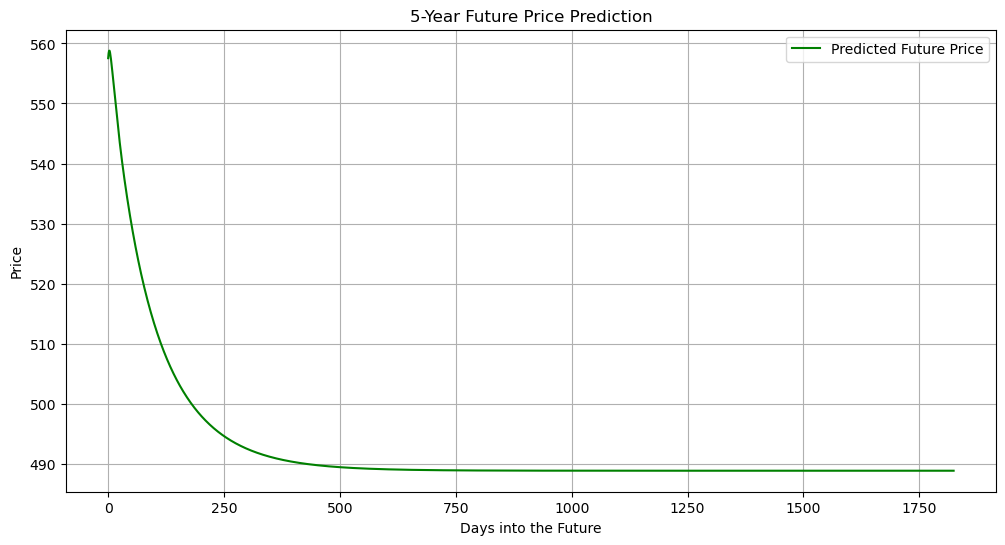

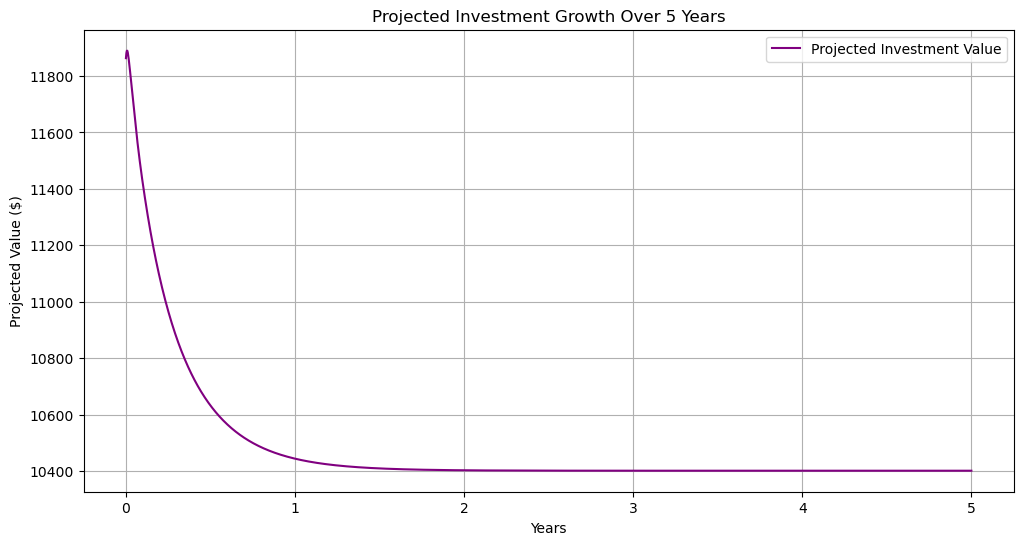

In [46]:
# Plot future price prediction
# Overfitted data leads to error in prediction
# Currently testing 1000 days/50 eopches with earlyStopping implemented to maximize the accuracy

plt.figure(figsize=(12, 6))
plt.plot(future_predictions, label='Predicted Future Price', color='green')
plt.title(f'{years}-Year Future Price Prediction')
plt.xlabel('Days into the Future')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Plot investment growth
plt.figure(figsize=(12, 6))
plt.plot(np.linspace(0, years, len(future_predictions)), future_predictions * (investment_amount / initial_price), color='purple', label='Projected Investment Value')
plt.title(f'Projected Investment Growth Over {years} Years')
plt.xlabel('Years')
plt.ylabel('Projected Value ($)')
plt.legend()
plt.grid(True)
plt.show()